Design a simulation of a self-driving cab. The major goal is to demonstrate, in a simplified environment, how you can use  Reinforcement Learning techniques to develop an efficient and safe approach for tackling this problem.

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:


1.   Drop off the passenger to the right location.
2.   Save passenger's time by taking minimum time possible to drop off.
3.   Take care of passenger's safety and traffic rules.







In [0]:
#!pip install cmake 'gym[atari]' scipy
#OpenAI Gym has the exact envirement already build for us 

In [2]:
import gym
env = gym.make("Taxi-v3").env
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



problem Restructured:

*  "There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."







In [3]:
env.reset()
env.render()
print("Action Space {}".format(env.action_space))
print("State Space  {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space  Discrete(500)


The filled square represents the taxi, which is yellow without a passenger and green with a passenger.The pipe ("|") represents a wall which the taxi cannot cross.R, G, Y, B are the possible pickup and destination locations. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.

In [4]:
# taxi row, taxi column, passenger index, destination index
state =env.encode(3,1,2,0)
print("State", state)
env.s=state 
env.render()

State 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [5]:
env.P[state]
#or
#env.p[328]
#The Output dictionary has the structure 
#{action: [(probability, nextstate, reward, done)]}

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

**Solving the environment without Reinforcement Learning**

In [6]:
#using an infinite loop, and based on our tanle P
#we can try to have our taxi navigate just using that.
#The loop runs until ne passenger reaches 
#one destination (one episode)
from six import StringIO

env.s=328
epochs=0
penalities, rewards=0,0
frames=[] #for animation

done =False

while not done:
  action=env.action_space.sample()
  state, rewards, done,info=env.step(action)
  if rewards ==-10:
    penalities += 1
    #Add the frame into dict animation 
    frames.append({
        'frame':  env.render('ansi'),
        'state' : state,
        'action': action,
        'reward': rewards})

  
  epochs +=1

print("Timesteps taken : {}" .format(epochs))
print("Penalities incurred: {}".format(penalities))


Timesteps taken : 2359
Penalities incurred: 778


In [7]:
from IPython.display import clear_output
from time import sleep
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)   
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Timestep: 778
State: 16
Action: 4
Reward: -10


**Enter Reinforcement Learning, Q-learning Algo**

In [0]:
#STEPS:

#Initialize the Q-table by all zeros.
#Start exploring actions: For each state, select any one among all possible actions for the current state (S).
#Travel to the next state (S') as a result of that action (a).
#For all possible actions from the state (S') select the one with the highest Q-value.
#Update Q-table values using the equation>>
#Q(state,action)←(1−α)Q(state,action)+α(reward+γmaxaQ(next state,all actions))
#Set the next state as the current state.
#If goal state is reached, then end and repeat the process.

In [0]:
#To avoid that the action takes always the same route, and yto prevente overfitting 
#we'll be introducing another parameter called ϵ "epsilon" to cater to this during training.

In [0]:
import numpy as np
q_table=np.zeros([env.observation_space.n, env.action_space.n])

In [25]:
#Now we create the training alogirthm to update this Q-table.
import random
from IPython.display import clear_output
#hyperparameters 
alpha=0.1
gamma=0.6
epsilon= 0.1
#for plots
all_epochs=[]
all_penalities=[]
untrained_frames = []


for i in range (1, 100001):
  state=env.reset()
  epochs,penalities, rewards=0,0,0
  done=False

  while not done :
    if random.uniform(0,1)<epsilon:
      #randdom sampling of an element from space
      action =env.action_space.sample()
    else:
      ## Exploit learned values
      action=np.argmax(q_table[state])
    next_state, reward, done, info=env.step(action)
    old_value=q_table[state, action]
    next_max=np.max(q_table[next_state])
    new_value=(1-alpha)*old_value+alpha*(reward+gamma*next_max)
    q_table[state, action]=new_value

    if rewards==-10:
      penalities +=1
    state=next_state
    epochs+=1
  if i%100==0:
    clear_output(wait=True)
    print(f"Episode: {i}")
print("Training finished.\n")

Episode: 100000
Training finished.



In [26]:
q_table[328]

array([ -2.41736201,  -2.27325184,  -2.41651658,  -2.36279173,
       -11.17151532, -11.22368601])

In [0]:
#after traning we see that the algorithm learned very well the next action 
#After state 328, the north is the best action for the agent, and also the algorithm 
#got the desired action to the north  with best q value (-2.27) 

**Evaluation**

In [42]:
rewardss = []
total_epochs, total_penalities=0,0
episodes=100
for _ in range (episodes):
  episode_rewards = []
  state=env.reset()
  epochs, penalities, rewards=0,0,0
  done=False
  while not done:
    action=np.argmax(q_table[state])
    state, rewards, done, info=env.step(action)
    episode_rewards.append(rewards)
    if reward==-10:
      penalities+=-1
    epochs+=1
  total_penalities+=penalities
  total_epochs+=epochs
  rewardss.append(np.mean(episode_rewards))
print(f"Results after {episodes}:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalities / episodes}")
env.close()

Results after 100:
Average timesteps per episode: 13.02
Average penalties per episode: 0.0


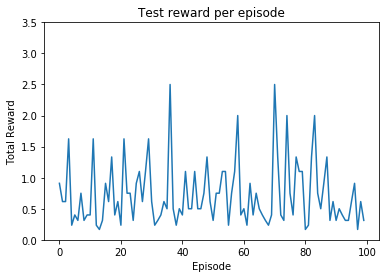

In [51]:
import matplotlib.pyplot as plt
plt.plot(rewardss)
plt.title("Test reward per episode")
plt.ylim((0, 3.5))
plt.xlabel('Episode');
plt.ylabel('Total Reward');